In [1]:
from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import accuracy_score,classification_report
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# import scikitplot as skplt
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
dataset = pd.read_csv("data.csv")

In [3]:
dataset.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


In [4]:
dataset.shape

(71044, 25)

In [5]:
dataset.isnull().sum()

id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews.date               67
reviews.dateAdded           0
reviews.dateSeen            0
reviews.didPurchase     38886
reviews.doRecommend     10615
reviews.id              38886
reviews.numHelpful      38536
reviews.rating              0
reviews.sourceURLs          0
reviews.text               36
reviews.title             477
reviews.userCity        65634
reviews.userProvince    70595
reviews.username          102
upc                         2
dtype: int64

# Data Cleaning

 Selecting Required Columns

In [6]:
dataset = dataset[['brand','manufacturer','reviews.didPurchase','reviews.rating', 'reviews.text']]

Checking Null Values

In [7]:
dataset.isnull().sum()

brand                      0
manufacturer             141
reviews.didPurchase    38886
reviews.rating             0
reviews.text              36
dtype: int64

Inputing null values on 'reviews.didpurchase' & Removing all the null values:

In [8]:
dataset['reviews.didPurchase'] = dataset['reviews.didPurchase'].fillna('Not Avialable')

In [9]:
dataset = dataset.dropna()

# Visualizing The Result:

In [10]:
data = dataset['reviews.rating'].value_counts()
data

reviews.rating
5    46451
4    14537
3     4350
1     3699
2     1830
Name: count, dtype: int64

<Axes: xlabel='reviews.rating'>

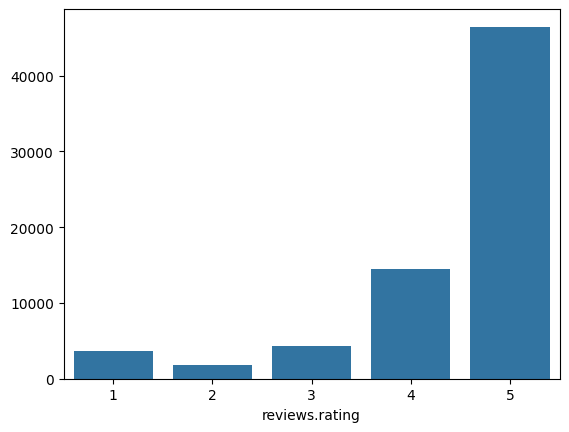

In [11]:
sns.barplot(x=data.index, y=data.values)

Need to map 1,2 - Unhappy, 3-OK and 4,5 - Happy

# Fake Reviews Provided by User:

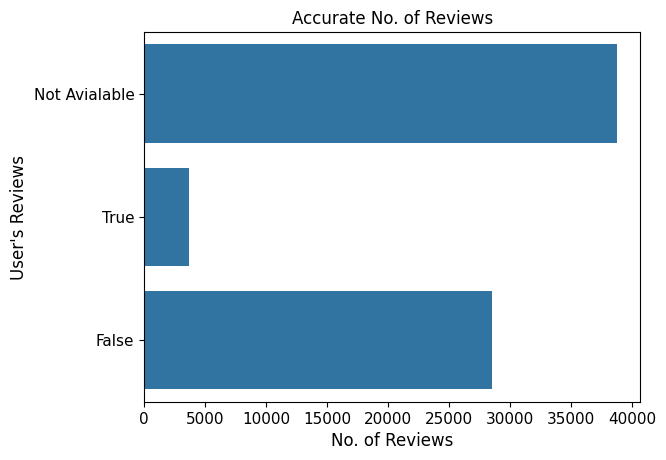

In [12]:
ax_plt = sns.countplot(dataset['reviews.didPurchase'])
ax_plt.set_xlabel(xlabel='No. of Reviews', fontsize=12)
ax_plt.set_ylabel(ylabel="User's Reviews", fontsize=12)
ax_plt.set_title('Accurate No. of Reviews', fontsize=12)
ax_plt.tick_params(labelsize=11)

True reviews are less in number and as you can see poeple who didn't even purchase the product has provided reviews these are all fake reviews which are much higher than those who have purchased and provided the review.

# Wordcloud

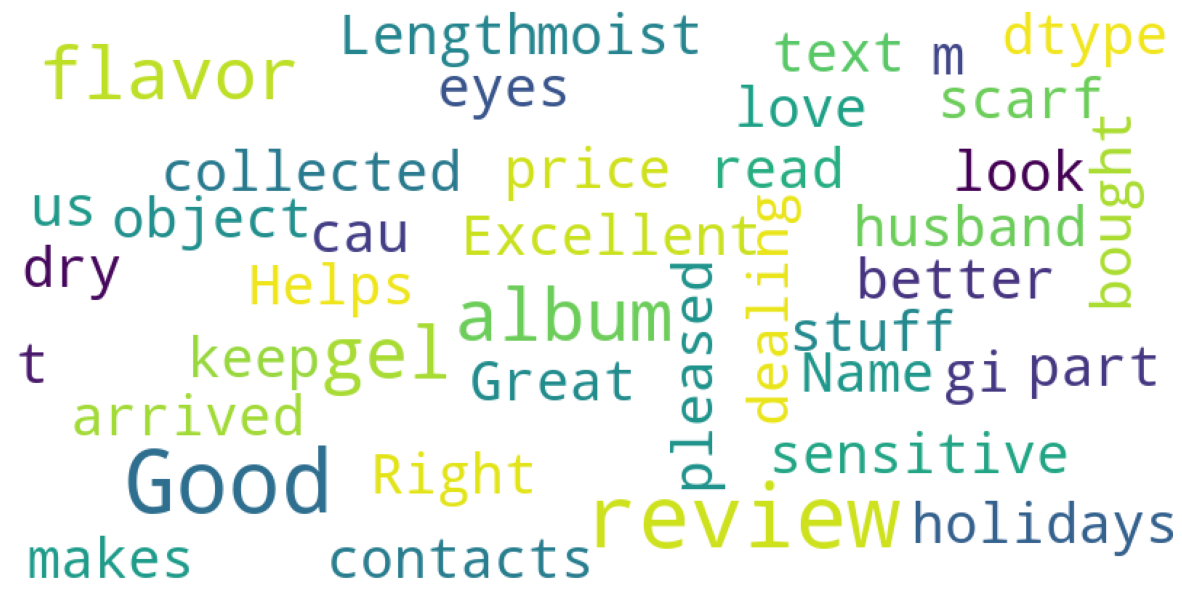

In [13]:
stopwords = set(STOPWORDS)
def wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=30,
        scale=2,
        random_state=5
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

wordcloud(dataset['reviews.text'])

# Feature Transformation:

In [14]:
data=dataset['reviews.text']
train_data=dataset['reviews.text']
y_target=dataset['reviews.rating'].map({1:'Unhappy',2:'Unhappy',3:'Ok',4:'Happy',5:'Happy'})

In [15]:
vectorize_word = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',stop_words='english',ngram_range=(1, 1),max_features=10000)
vectorize_word.fit(data)
train_features_word = vectorize_word.transform(train_data)

In [16]:
vectorize_char = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',stop_words='english',ngram_range=(2, 6),max_features=50000)
vectorize_char.fit(data)
train_features_char = vectorize_char.transform(train_data)
train_features = hstack([train_features_char, train_features_word])

c:\Users\IRTAZA MANZOOR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:543: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_features, y_target,test_size=0.3,random_state=101,shuffle=True)

# SVC Model:

In [18]:
lsvm = LinearSVC(class_weight='balanced')
l = lsvm.fit(X_train,y_train)

Linear SVC Metric Over Training:

In [19]:
pred_train = l.predict(X_train)

In [20]:
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.9886908841672378
              precision    recall  f1-score   support

       Happy       1.00      0.99      0.99     42745
          Ok       0.89      0.97      0.93      3014
     Unhappy       0.97      1.00      0.99      3847

    accuracy                           0.99     49606
   macro avg       0.95      0.99      0.97     49606
weighted avg       0.99      0.99      0.99     49606



Linear SVC Metric Over Test:

In [21]:
pred_test=l.predict(X_test)

In [22]:
print("Accuracy Test : {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Test : 0.9013216687832181
              precision    recall  f1-score   support

       Happy       0.95      0.95      0.95     18243
          Ok       0.39      0.38      0.39      1336
     Unhappy       0.75      0.74      0.75      1682

    accuracy                           0.90     21261
   macro avg       0.70      0.69      0.70     21261
weighted avg       0.90      0.90      0.90     21261



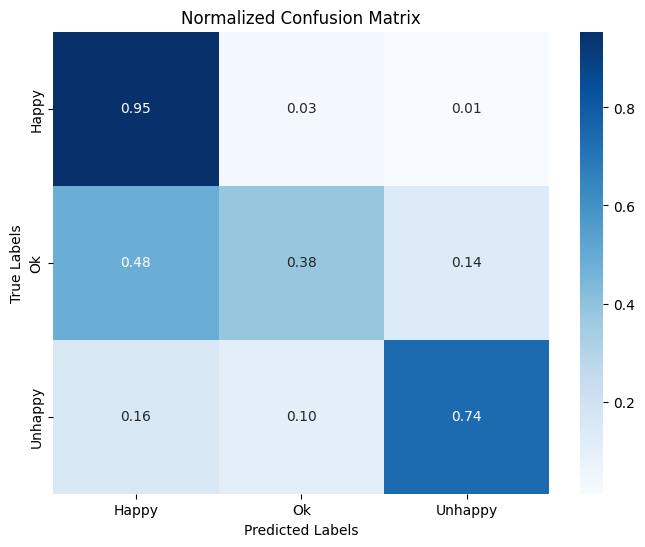

In [23]:

cm = confusion_matrix(y_test, pred_test, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Happy', 'Ok', 'Unhappy'], yticklabels=['Happy', 'Ok','Unhappy'])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [24]:
joblib.dump(lsvm, "linear_svc_model.pkl")
joblib.dump(vectorize_word, "vectorize_word.pkl")
joblib.dump(vectorize_char, "vectorize_char.pkl")

['vectorize_char.pkl']

# SGD Classifier:

In [79]:
svm1=SGDClassifier(class_weight='balanced',n_jobs=-1, max_iter=300)
svm1.fit(X_train,y_train)

SGDClassifier(class_weight='balanced', max_iter=300, n_jobs=-1)

SGD Metric Over Training:

In [80]:
pred_train_sgd=svm1.predict(X_train)
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train_sgd)))
print(classification_report(y_train,pred_train_sgd))

Accuracy Train: 0.9398459863726162
              precision    recall  f1-score   support

       Happy       0.98      0.96      0.97     42745
          Ok       0.62      0.70      0.66      3014
     Unhappy       0.83      0.89      0.85      3847

    accuracy                           0.94     49606
   macro avg       0.81      0.85      0.83     49606
weighted avg       0.94      0.94      0.94     49606



SGD Metric Over Test:

In [81]:
pred_test_sgd=svm1.predict(X_test)
print("Accuracy Test: {}".format(accuracy_score(y_test,pred_test_sgd)))
print(classification_report(y_test,pred_test_sgd))

Accuracy Test: 0.8996284276374582
              precision    recall  f1-score   support

       Happy       0.95      0.95      0.95     18243
          Ok       0.40      0.39      0.40      1336
     Unhappy       0.71      0.75      0.73      1682

    accuracy                           0.90     21261
   macro avg       0.69      0.70      0.69     21261
weighted avg       0.90      0.90      0.90     21261



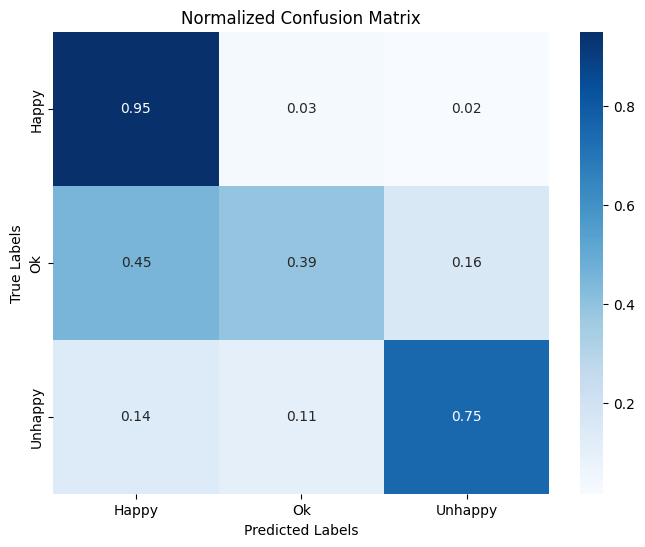

In [82]:
cm = confusion_matrix(y_test, pred_test_sgd, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Happy', 'Ok', 'Unhappy'], yticklabels=['Happy', 'Ok','Unhappy'])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Training KNN...
KNN - Train Accuracy: 0.8957, Test Accuracy: 0.8792
              precision    recall  f1-score   support

       Happy       0.88      0.99      0.93     18243
          Ok       0.43      0.05      0.09      1336
     Unhappy       0.88      0.29      0.44      1682

    accuracy                           0.88     21261
   macro avg       0.73      0.44      0.49     21261
weighted avg       0.85      0.88      0.84     21261



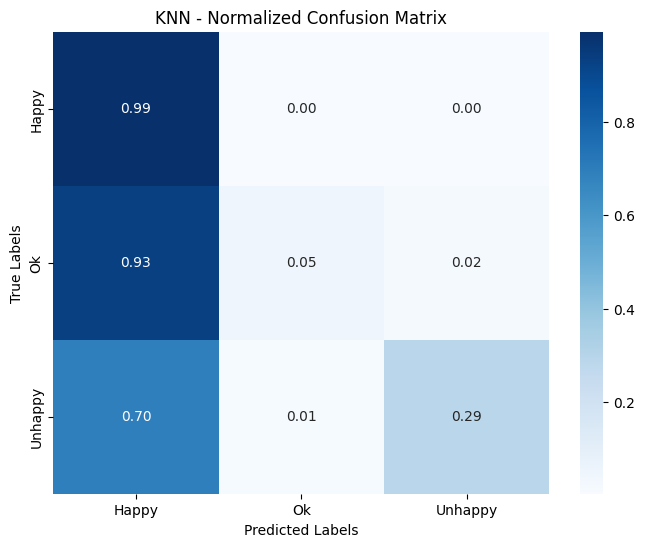

Training LinearSVC...
LinearSVC - Train Accuracy: 0.9887, Test Accuracy: 0.9013
              precision    recall  f1-score   support

       Happy       0.95      0.95      0.95     18243
          Ok       0.39      0.38      0.39      1336
     Unhappy       0.75      0.74      0.75      1682

    accuracy                           0.90     21261
   macro avg       0.70      0.69      0.70     21261
weighted avg       0.90      0.90      0.90     21261



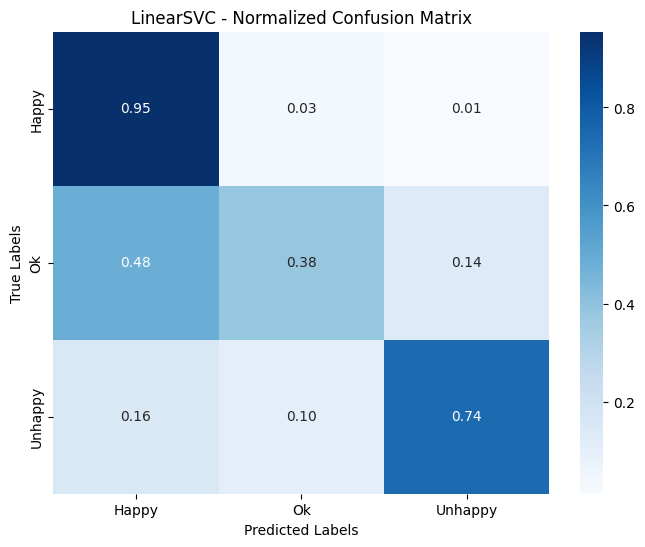

Training SGDClassifier...
SGDClassifier - Train Accuracy: 0.9390, Test Accuracy: 0.8995
              precision    recall  f1-score   support

       Happy       0.95      0.95      0.95     18243
          Ok       0.40      0.41      0.40      1336
     Unhappy       0.72      0.75      0.74      1682

    accuracy                           0.90     21261
   macro avg       0.69      0.70      0.70     21261
weighted avg       0.90      0.90      0.90     21261



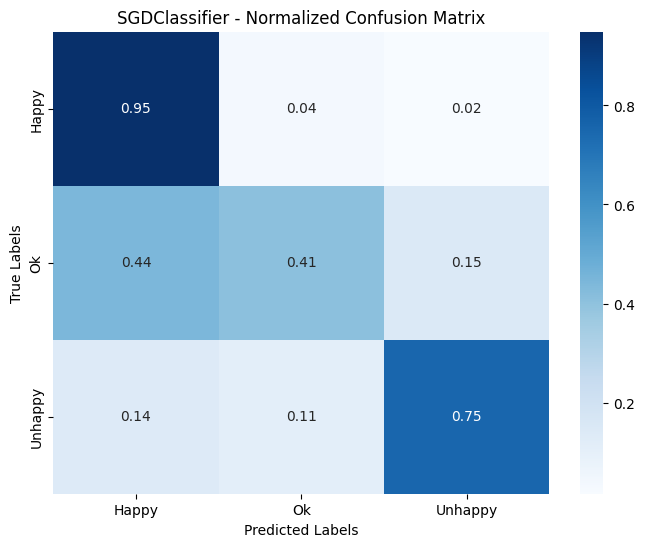

Training LogisticRegression...
LogisticRegression - Train Accuracy: 0.9187, Test Accuracy: 0.8549
              precision    recall  f1-score   support

       Happy       0.97      0.88      0.92     18243
          Ok       0.29      0.55      0.38      1336
     Unhappy       0.63      0.79      0.70      1682

    accuracy                           0.85     21261
   macro avg       0.63      0.74      0.67     21261
weighted avg       0.90      0.85      0.87     21261



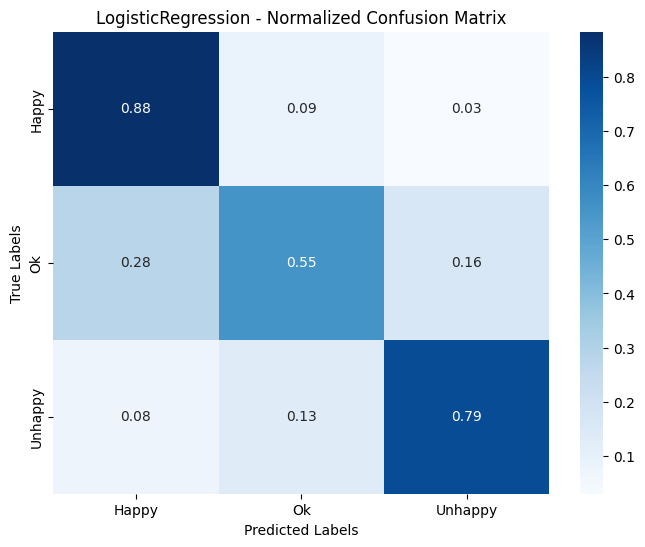

Training RandomForest...
RandomForest - Train Accuracy: 0.9999, Test Accuracy: 0.8962
              precision    recall  f1-score   support

       Happy       0.89      1.00      0.94     18243
          Ok       0.92      0.12      0.22      1336
     Unhappy       0.94      0.40      0.57      1682

    accuracy                           0.90     21261
   macro avg       0.92      0.51      0.57     21261
weighted avg       0.90      0.90      0.87     21261



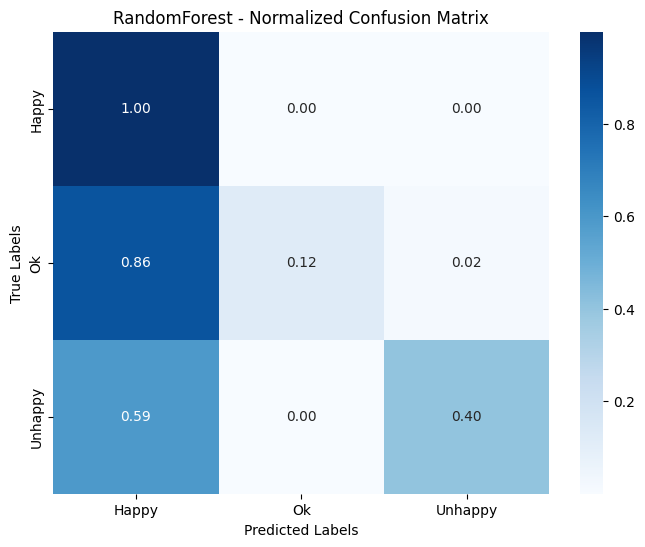

Training NaiveBayes...
NaiveBayes - Train Accuracy: 0.8801, Test Accuracy: 0.8652
              precision    recall  f1-score   support

       Happy       0.94      0.93      0.93     18243
          Ok       0.33      0.21      0.26      1336
     Unhappy       0.52      0.73      0.60      1682

    accuracy                           0.87     21261
   macro avg       0.60      0.62      0.60     21261
weighted avg       0.87      0.87      0.86     21261



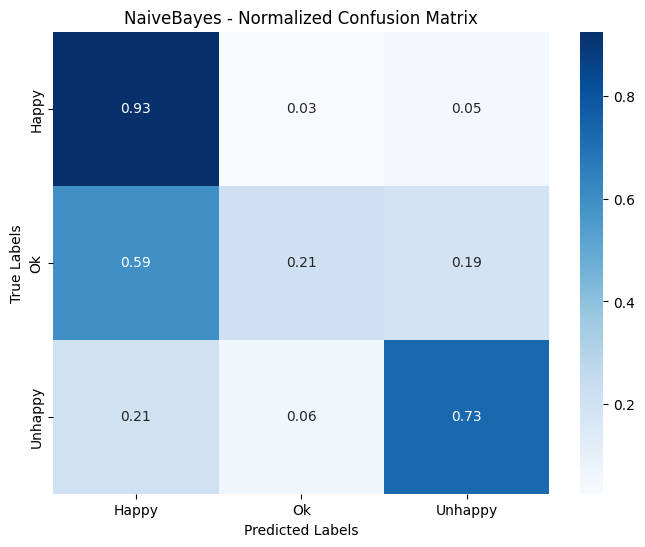

C:\Users\IRTAZA MANZOOR\AppData\Local\Temp\ipykernel_22160\598720442.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test Accuracy", data=results_df, palette="viridis")


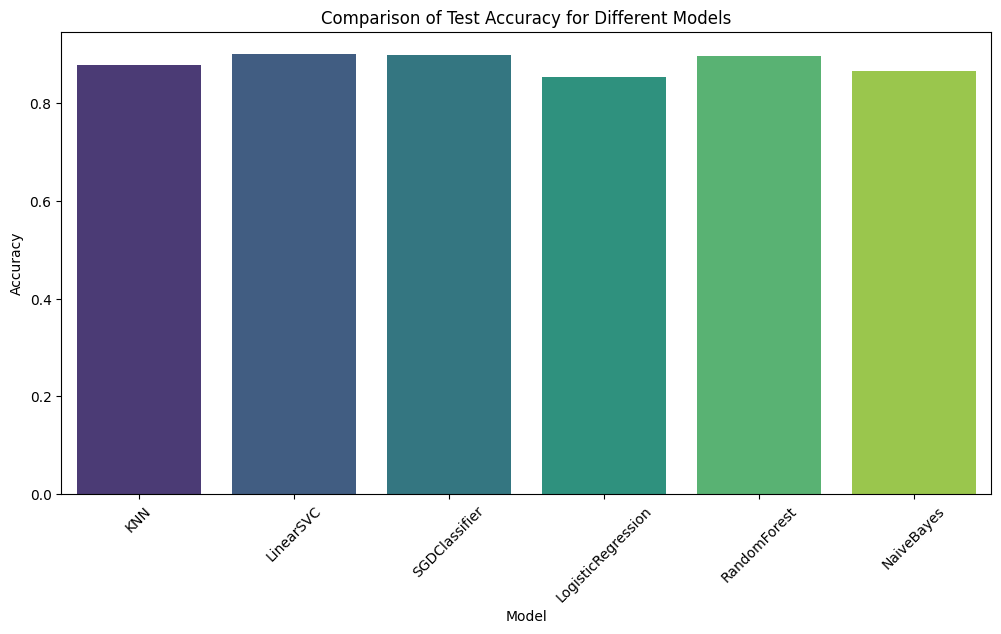

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# Dictionary to store models and their accuracy scores
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "LinearSVC": LinearSVC(class_weight='balanced'),
    "SGDClassifier": SGDClassifier(class_weight='balanced', n_jobs=-1, max_iter=300),
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=300),
    "RandomForest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "NaiveBayes": MultinomialNB(),
}

# Dataframe to store results
results = {"Model": [], "Train Accuracy": [], "Test Accuracy": []}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # Accuracy scores
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)
    
    # Classification report
    print(f"{model_name} - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, pred_test))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, pred_test, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Happy', 'Ok', 'Unhappy'], yticklabels=['Happy', 'Ok', 'Unhappy'])
    plt.title(f"{model_name} - Normalized Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    # Save results
    results["Model"].append(model_name)
    results["Train Accuracy"].append(train_acc)
    results["Test Accuracy"].append(test_acc)

# Plot comparison of model accuracy



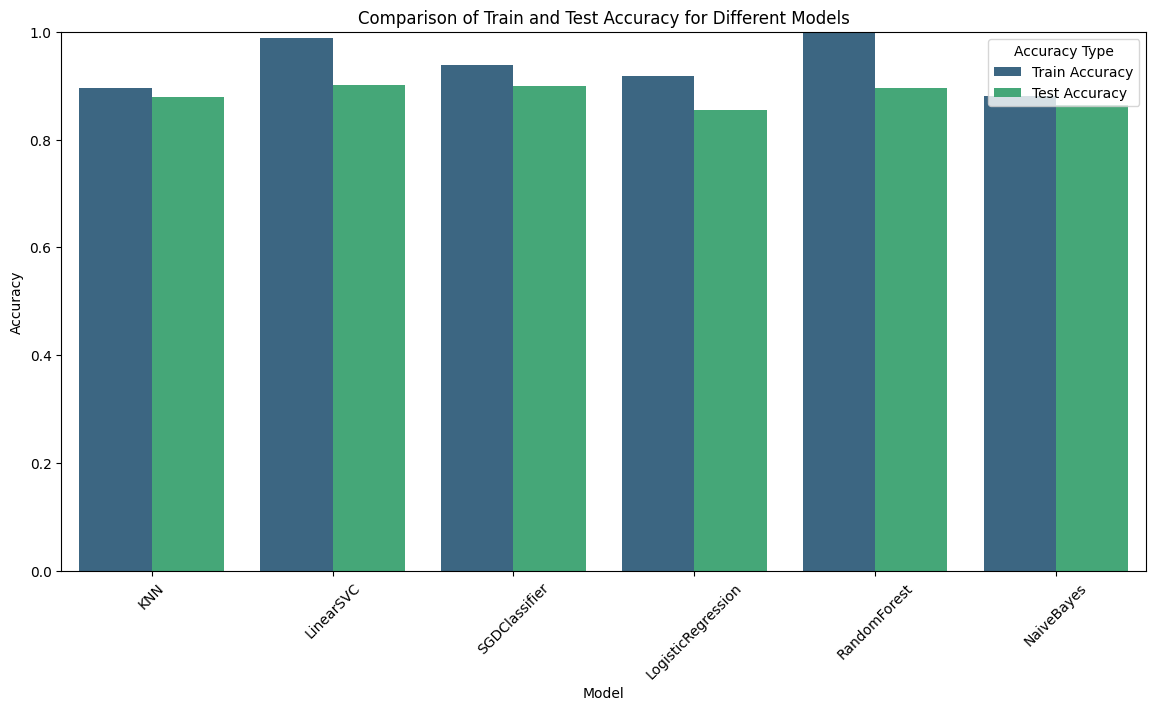

In [95]:
results_df = pd.DataFrame(results)
# Reshape results data to long format for visualization
results_long = pd.melt(
    results_df,
    id_vars=["Model"],  # Keep model names as identifiers
    value_vars=["Train Accuracy", "Test Accuracy"],  # Columns to transform into rows
    var_name="Accuracy Type",  # Name for the new column identifying accuracy type
    value_name="Accuracy",  # Name for the new column containing accuracy values
)

# Plot train and test accuracy
plt.figure(figsize=(14, 7))
sns.barplot(x="Model", y="Accuracy", hue="Accuracy Type", data=results_long, palette="viridis")
plt.title("Comparison of Train and Test Accuracy for Different Models")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Assuming accuracy values are between 0 and 1
plt.legend(title="Accuracy Type")
plt.show()


In [96]:
results_df

,Model,Train Accuracy,Test Accuracy
0,KNN,0.895718,0.879168
1,LinearSVC,0.988691,0.901322
2,SGDClassifier,0.939040,0.899487
3,LogisticRegression,0.918679,0.854946
4,RandomForest,0.999899,0.896242
5,NaiveBayes,0.880135,0.865246
